### recap拆分分子，同时知晓分子片段在原分子中对应的所有原子位置

### recap拆分分子 知晓分子片段在分子中的对应原子编号

In [2]:
from rdkit import Chem
from rdkit.Chem import Recap
from rdkit.Chem import  Draw  

In [57]:
import re
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import AllChem

def correct_benzene_rings(correct, smiles):
    if not correct:
        print("origin:", smiles)
        return smiles
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
    
        ring_info = mol.GetRingInfo()
        atom_rings = ring_info.AtomRings()
    
        for ring in atom_rings:
            ring_atoms = [mol.GetAtomWithIdx(idx) for idx in ring]
            bond_types = [bond.GetBondType() for bond in [mol.GetBondBetweenAtoms(ring[i], ring[(i + 1) % len(ring)]) for i in range(len(ring))]]
        
            # Correcting benzene-like rings
            if len(ring) == 6 and bond_types.count(Chem.rdchem.BondType.DOUBLE) > 1:
                for bond in [mol.GetBondBetweenAtoms(ring[i], ring[(i + 1) % len(ring)]) for i in range(len(ring))]:
                    bond.SetBondType(Chem.rdchem.BondType.AROMATIC)
                    bond.SetIsAromatic(True)
                for atom in ring_atoms:
                    atom.SetIsAromatic(True)
    
        # Converting consecutive C=C double bonds to single bonds
        for bond in mol.GetBonds():
            if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
                atom1 = bond.GetBeginAtom()
                atom2 = bond.GetEndAtom()
                
                # Check if both atoms are carbon and if they have other double bonds
                if atom1.GetAtomicNum() == 6 and atom2.GetAtomicNum() == 6:
                    double_bond_count = 0
                    for b in atom1.GetBonds():
                        if b.GetBondType() == Chem.rdchem.BondType.DOUBLE and b != bond:
                            double_bond_count += 1
                    for b in atom2.GetBonds():
                        if b.GetBondType() == Chem.rdchem.BondType.DOUBLE and b != bond:
                            double_bond_count += 1
                    if double_bond_count > 1:
                        bond.SetBondType(Chem.rdchem.BondType.SINGLE)
                        bond.SetIsAromatic(False)

        # Adjusting large rings with alternating single and double bonds if no side chains are present
        for ring in atom_rings:
            if len(ring) > 6:
                has_side_chains = any(
                    len(atom.GetNeighbors()) > 2 or 
                    (len(atom.GetNeighbors()) == 2 and any(n.GetIdx() not in ring for n in atom.GetNeighbors()))
                    for atom in ring_atoms
                )
                print('has_side_chains:', has_side_chains)
                if not has_side_chains:
                    for i in range(len(ring)):
                        bond = mol.GetBondBetweenAtoms(ring[i], ring[(i + 1) % len(ring)])
                        if i % 2 == 0:
                            bond.SetBondType(Chem.rdchem.BondType.SINGLE)
                        else:
                            bond.SetBondType(Chem.rdchem.BondType.DOUBLE)
                        bond.SetIsAromatic(False)
    
        # Normalize and check the molecule
        try:
            AllChem.SanitizeMol(mol)
            cor_smile = Chem.MolToSmiles(mol, kekuleSmiles=False)
            print(cor_smile)
            return cor_smile
        except Exception as e:
            # If sanitization fails, adjust valence and try again
            for atom in mol.GetAtoms():
                current_valence = sum(bond.GetBondTypeAsDouble() for bond in atom.GetBonds())
                if current_valence > atom.GetImplicitValence():
                    for bond in mol.GetBonds():
                        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
                            bond.SetBondType(Chem.rdchem.BondType.SINGLE)
                            bond.SetIsAromatic(False)
            try:
                AllChem.SanitizeMol(mol)
                cor_smile = Chem.MolToSmiles(mol, kekuleSmiles=False)
                print(cor_smile)
                return cor_smile
            except Exception as e:
                return "C"
            
    except Exception as e:
        print(f"Error!!! processing SMILES {smiles}: {e}")
        return smiles


In [58]:
# aspirin = Chem.MolFromSmiles('O=C(NC1CCC(=O)N(C(CSc2ccccc2)Cc2ccccc2)CC1)OCc1ccccc1')  

# def mol_with_atom_index( mol ):
#     atoms = mol.GetNumAtoms()
#     for idx in range( atoms ):
#         mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
#     return mols

# mol_with_atom_index(aspirin)
# Draw.MolsToGridImage([aspirin], molsPerRow=1, subImgSize=(1000,1000))  


# mol1 = Chem.MolFromSmiles(correct_benzene_rings('C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCC)c(O)c(O)c2O)cc1'))  
# mol2 = Chem.MolFromSmiles("CC(C)(C)c1cccc2c1S(=O)(=O)c1ccc(cc1)NC(=O)c1cc(c(O)c(O)c1O)CC=C=C=C=CCC[SH]2F")
# mol3 = Chem.MolFromSmiles("C=C=C=C=CCc1cc2c(O)c(c1O)OCC(=O)O[SH](=O)(c1ccccc1C(C)(C)C)c1ccc(cc1)NC2=O")

# mol5 = Chem.MolFromSmiles('C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCC)c(OO)c(O)c2O)cc1')


# def mol_with_atom_index( mol ):
#     atoms = mol.GetNumAtoms()
#     for idx in range( atoms ):
#         mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
#     return mol

# mol_with_atom_index(aspirin)
# Draw.MolsToGridImage([ mol1, mol4, mol7], molsPerRow=3, subImgSize=(500,500)) 
# Draw.MolsToGridImage([mol0, mol1, mol2, mol3, mol4, mol5, mol6], molsPerRow=4, subImgSize=(300,300)) 
# 
# 
# Generate the grid image with SMILES strings as legends

mol0 = Chem.MolFromSmiles(correct_benzene_rings(False, 'CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(N2C(=O)c3cc(c(O)c(O)c3O)CC=C=C=C=CC2COO)cc1'))  
mol1 = Chem.MolFromSmiles(correct_benzene_rings(False, 'C=CC(C)(C)c1=c=c=c=c=c1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCC)c(OO)c(O)c2O)cc1'))
mol2 = Chem.MolFromSmiles(correct_benzene_rings(False, 'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(C1C=C=C=C=CC1C)c(OO)c(O)c2O)cc1'))

mol0_c = Chem.MolFromSmiles(correct_benzene_rings(True, 'CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(N2C(=O)c3cc(c(O)c(O)c3O)CC=C=C=C=CC2COO)cc1'))  
mol1_c = Chem.MolFromSmiles(correct_benzene_rings(True, 'C=CC(C)(C)c1=c=c=c=c=c1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCC)c(OO)c(O)c2O)cc1'))
mol2_c = Chem.MolFromSmiles(correct_benzene_rings(True, 'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(C1C=C=C=C=CC1C)c(OO)c(O)c2O)cc1'))
img = Draw.MolsToGridImage([ mol0, mol1, mol2, mol0_c, mol1_c, mol2_c, ], molsPerRow=3, subImgSize=(1000, 1000), returnPNG=False)
# img = 
       
img.save(f'/home/lk/project/repaint/MolPaint/log/mol_correct_compare/test2.pdf') 



origin: CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(N2C(=O)c3cc(c(O)c(O)c3O)CC=C=C=C=CC2COO)cc1
origin: C=CC(C)(C)c1=c=c=c=c=c1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCC)c(OO)c(O)c2O)cc1
origin: C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(C1C=C=C=C=CC1C)c(OO)c(O)c2O)cc1
has_side_chains: True
CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(N2C(=O)c3cc(c(O)c(O)c3O)CCCCCCC2COO)cc1
CCCCCCCCc1cc(C(=O)Nc2ccc(S(=O)(=O)c3ccccc3C(C)(C)CC)cc2)c(O)c(O)c1OO
has_side_chains: True
has_side_chains: True
CCC(C)(C)c1ccccc1S(=O)(=O)C1CCC2CCC(C)CCCCCC1c1cc(c(O)c(O)c1OO)C(=O)N2


In [26]:
from rdkit import Chem
from rdkit.Chem import Draw

# Define the molecules with their SMILES strings
mol1_smiles = 'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCCS)c(O)c(O)c2O)cc1'
mol4_smiles = 'C=CC(C)(C)c1=c=c=c=c=c1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCC)c(OO)c(O)c2O)cc1'
mol5_smiles = 'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(CC=C=C=C=CCC)c(OO)c(O)c2O)cc1'
mol6_smiles = 'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc(NC(=O)c2cc(C1C=C=C=C=CC1C)c(OO)c(O)c2O)cc1'

# Create molecule objects from SMILES
mol1 = Chem.MolFromSmiles(mol1_smiles)
mol4 = Chem.MolFromSmiles(mol4_smiles)
mol5 = Chem.MolFromSmiles(mol5_smiles)
mol6 = Chem.MolFromSmiles(mol6_smiles)

# List of molecules and corresponding SMILES strings
mols = [mol1, mol4, mol5, mol6]


# List of molecules and corresponding SMILES strings with line breaks for three-line display
smiles_list = [
    'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc\n(NC(=O)c2cc(CC=C=C=C=CCCS)\nc(O)c(O)c2O)cc1',
    'C=CC(C)(C)c1=c=c=c=c=c1S(=O)(=O)c1ccc\n(NC(=O)c2cc(CC=C=C=C=CCC)\nc(OO)c(O)c2O)cc1',
    'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc\n(NC(=O)c2cc(CC=C=C=C=CCC)\nc(OO)c(O)c2O)cc1',
    'C=CC(C)(C)c1ccccc1S(=O)(=O)c1ccc\n(NC(=O)c2cc(C1C=C=C=C=CC1C)\nc(OO)c(O)c2O)cc1'
]

# smiles_list = [mol1_smiles, mol4_smiles, mol5_smiles, mol6_smiles]

# Generate the grid image with SMILES strings as legends
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(1000, 1000), returnPNG=False)

       
img.save(f'/home/lk/project/repaint/MolPaint/log/mol_correct_compare/test2.pdf')


Optimized SMILES: C=C(C)C(C)CC(NC(=O)CCc1cccc(C)c1)B(O)OO


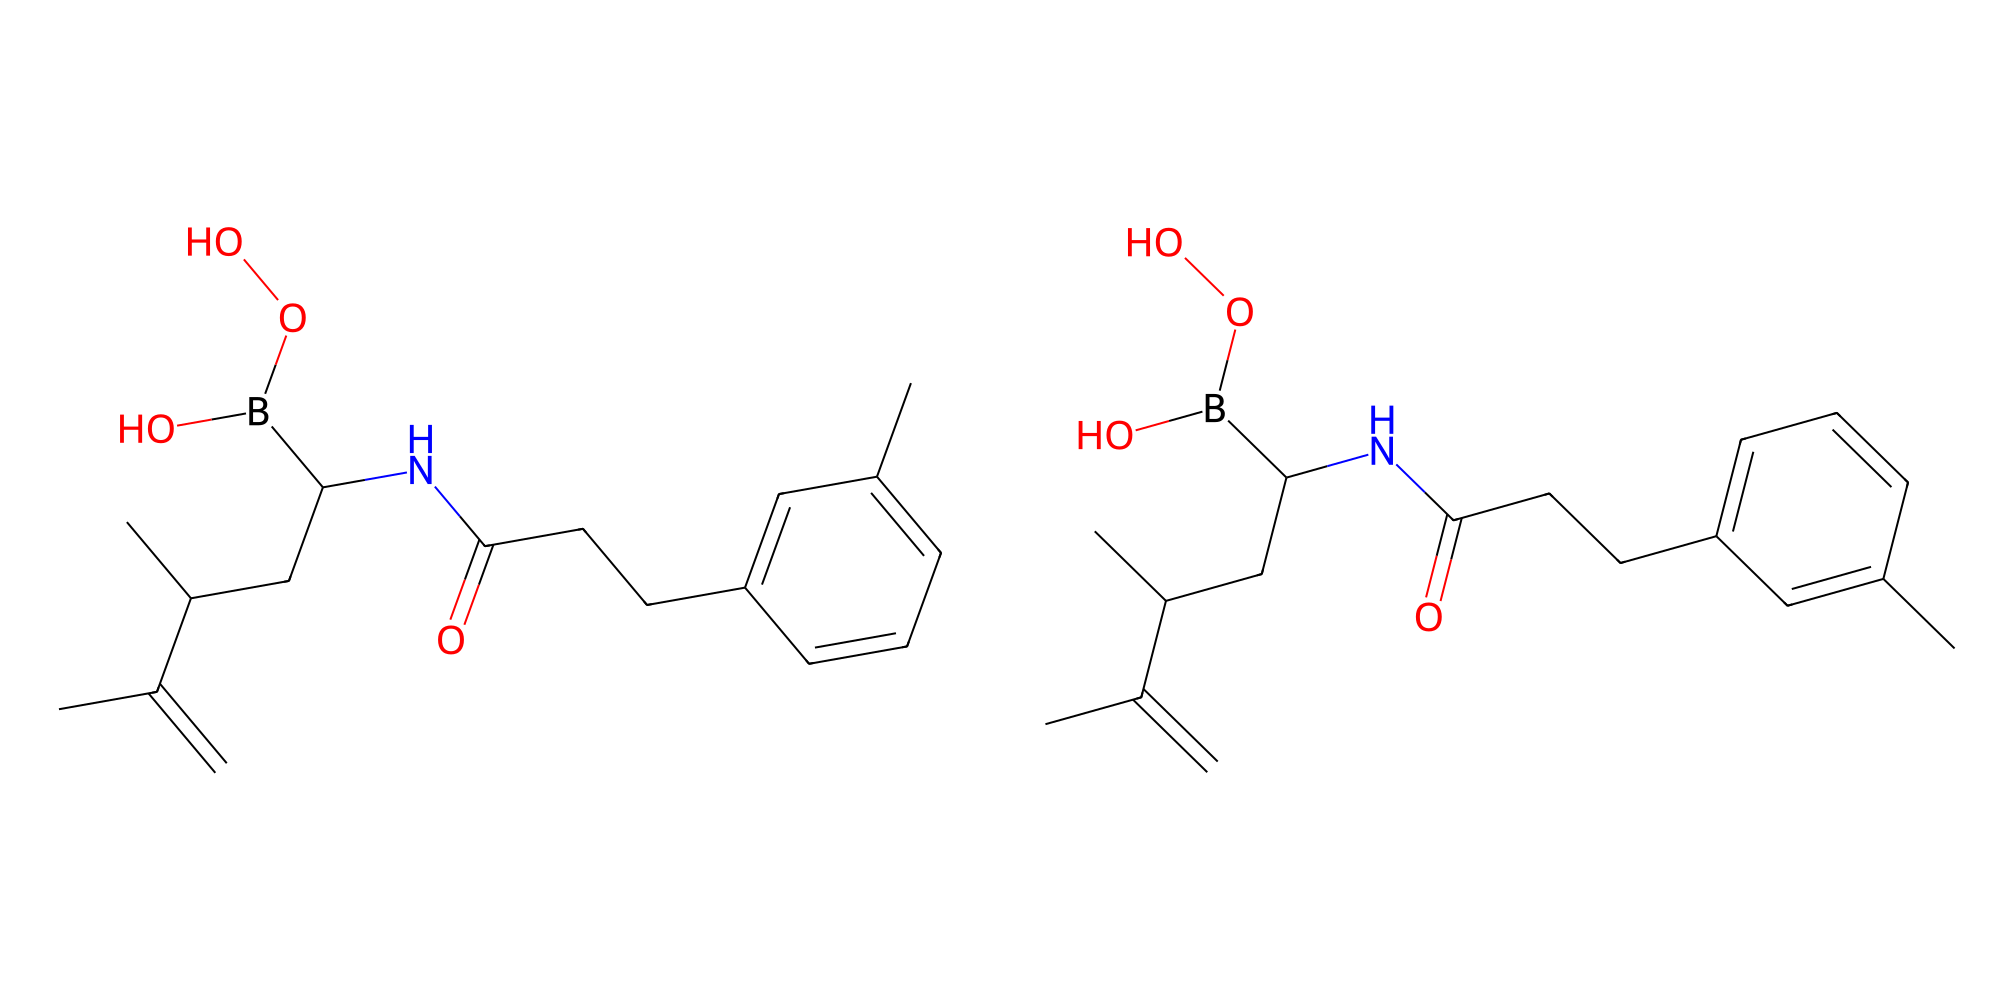

In [41]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms

# 将 SMILES 字符串转化为分子对象
# smiles = 'c=c(c)c(c)cc(Nc(=O)ccc1=c=c(c)c=c=c1)B(O)OO'
smiles = 'C=C(C)C(C)CC(NC(=O)CCc1cc(C)ccc1)B(O)OO'
mol = Chem.MolFromSmiles(smiles)

# 检查分子是否有效
if mol is None:
    print("Invalid molecule")
else:
    # 添加氢原子
    mol = Chem.AddHs(mol)

    # 生成 3D 坐标
    AllChem.EmbedMolecule(mol, randomSeed=42)

    # 优化分子几何结构
    AllChem.UFFOptimizeMolecule(mol)

    # 转化为 2D 坐标
    AllChem.Compute2DCoords(mol)

    # 绘制分子结构
    from rdkit.Chem import Draw
    # Draw.MolToImage(mol, size=(300, 300))
    

    # 检查并修复常见结构问题
    # 例如，检测并修复芳香环
    Chem.SanitizeMol(mol)
    mol = Chem.RemoveHs(mol)
    # 转化为 SMILES 字符串
    optimized_smiles = Chem.MolToSmiles(mol)
    print("Optimized SMILES:", optimized_smiles)
    
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles), Chem.MolFromSmiles(optimized_smiles)  ], molsPerRow=2, subImgSize=(1000,1000))  


Optimized SMILES: C=C(C)C(C)CC(NC(=O)CCC1CCCC(C)C1)B(O)OO


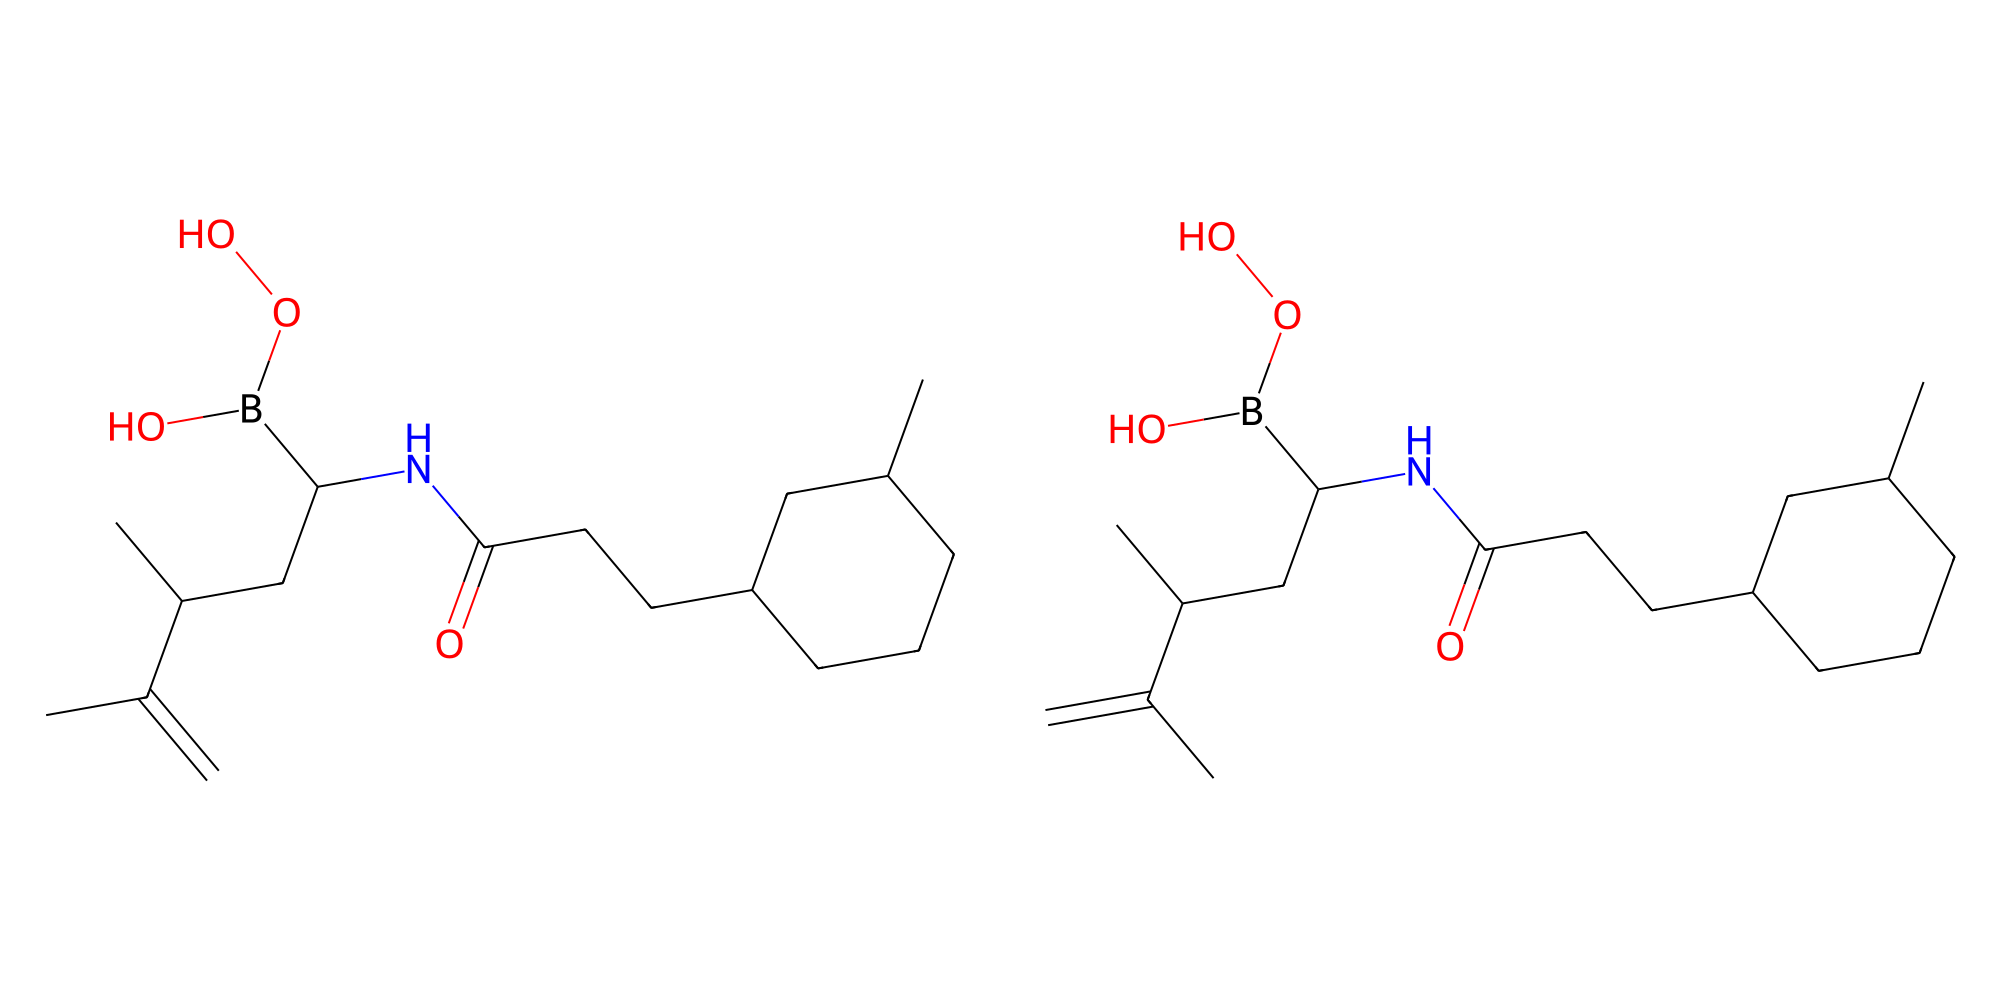

In [32]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms

# 将 SMILES 字符串转化为分子对象
smiles = 'C=C(C)C(C)CC(NC(=O)CCC1=C=C(C)C=C=C1)B(O)OO'
mol = Chem.MolFromSmiles(smiles)

# 检查分子是否有效
if mol is None:
    print("Invalid molecule")
else:
    # 添加氢原子
    mol = Chem.AddHs(mol)

    # 生成 3D 坐标
    AllChem.EmbedMolecule(mol, randomSeed=42)

    # 优化分子几何结构
    AllChem.UFFOptimizeMolecule(mol)

    # 再次去除氢原子
    mol = Chem.RemoveHs(mol)

    # 优化后的 SMILES 字符串
    optimized_smiles = Chem.MolToSmiles(mol)
    print("Optimized SMILES:", optimized_smiles)

    # 转化为 2D 坐标
    AllChem.Compute2DCoords(mol)

# 绘制分子结构
from rdkit.Chem import Draw

Draw.MolsToGridImage([Chem.MolFromSmiles(smiles), mol  ], molsPerRow=2, subImgSize=(1000,1000))  



fragment without star: CC(C)C[C@H](N)B(O)O
fragment: *N[C@@H](CC(C)C)B(O)O
fragment without star: O=Cc1cnccn1
fragment: *C(=O)c1cnccn1
fragment without star: N[C@H](C=O)Cc1ccccc1
fragment: *N[C@@H](Cc1ccccc1)C(*)=O


[05:38:39] WARNING: not removing hydrogen atom without neighbors
[05:38:39] WARNING: not removing hydrogen atom without neighbors
[05:38:39] WARNING: not removing hydrogen atom without neighbors
[05:38:39] WARNING: not removing hydrogen atom without neighbors
[05:38:39] WARNING: not removing hydrogen atom without neighbors
[05:38:39] WARNING: not removing hydrogen atom without neighbors


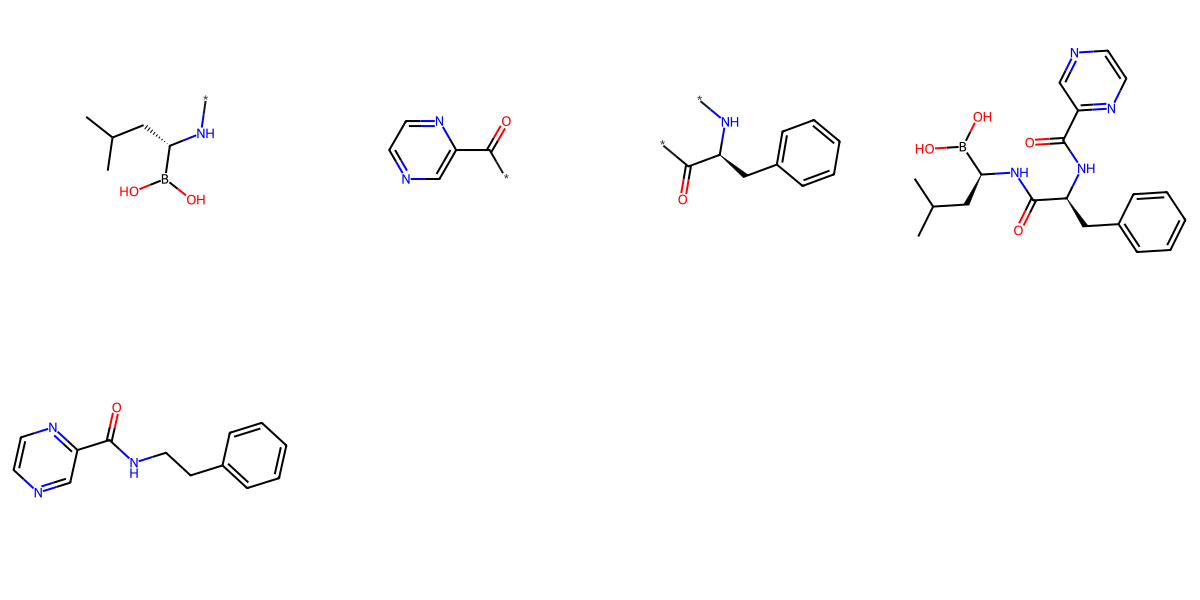

In [48]:
from rdkit.Chem import  Draw  
from rdkit.Chem.Scaffolds import MurckoScaffold
def delete_star(smiles):
    # 将 SMILES 转换为 RDKit 分子对象
    mol = Chem.MolFromSmiles(smiles)
    # 将通配符替换为氢原子
    mol = Chem.ReplaceSubstructs(mol, Chem.MolFromSmiles('*'), Chem.MolFromSmiles('[H]'), replaceAll=True)[0]
    mol = Chem.RemoveHs(mol)
    return Chem.MolToSmiles(mol)

aspirin = Chem.MolFromSmiles('B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C2=NC=CN=C2)(O)O')  
unique_fragments = []

    
fragments = Recap.RecapDecompose(aspirin).GetLeaves().keys()

for fragment in fragments:
    unique_fragments.append(delete_star(fragment))
    print('fragment without star:',delete_star(fragment))
    print('fragment:',fragment)
    
toshow = [Chem.MolFromSmiles(frag) for frag in fragments]
toshow.append(aspirin)

core = MurckoScaffold.GetScaffoldForMol(aspirin)
toshow.append(core)
Draw.MolsToGridImage(toshow, molsPerRow=4, subImgSize=(300,300))  


In [ ]:
Draw.MolsToGridImage([Chem.MolFromSmiles(frag) for frag in unique_fragments], molsPerRow=4, subImgSize=(300,300))  

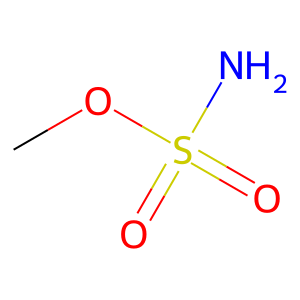

In [94]:
# print(res_)
Draw.MolsToGridImage([res_], molsPerRow=1, subImgSize=(300,300))  

CC(C)C[C@H](N)B(O)O

 CC(C)C[C@H](N)B(O)O  matched atom id:  ((4, 3, 5, 2, 1, 6, 0, 26, 27),)
O=Cc1cnccn1
N[C@H](C=O)Cc1ccccc1

 N[C@H](C=O)Cc1ccccc1  matched atom id:  ((17, 9, 7, 8, 10, 11, 12, 13, 14, 15, 16),)


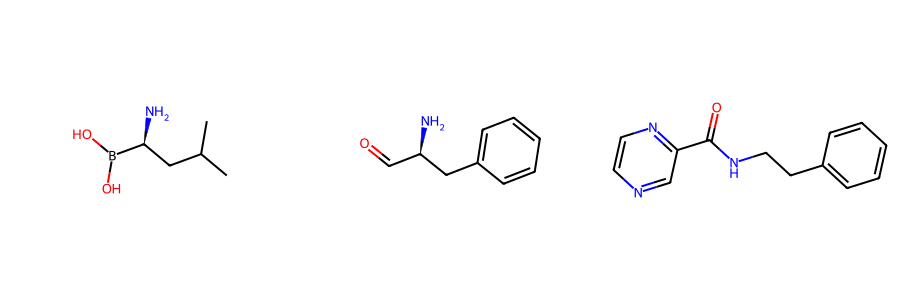

In [56]:
toshow_frag = []

for fragment in unique_fragments:
    print(fragment)
    patt = Chem.MolFromSmiles(fragment)
    flag = core.HasSubstructMatch(patt)
    if not flag:
        atomids = aspirin.GetSubstructMatches(patt)
        print('\n',fragment, " matched atom id: ",atomids)
        toshow_frag.append(patt)
        
toshow_frag.append(core)
   
Draw.MolsToGridImage(toshow_frag, molsPerRow=3, subImgSize=(300,300))  

In [31]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold


import pandas as pd

def get_unique_smiles(file_path):
    # 读取CSV文件
    df = pd.read_csv(file_path)
    
    # 获取不重复的smiles列值
    unique_smiles = df['smiles'].drop_duplicates().tolist()
    
    return unique_smiles

def delete_star(mol):
    # 将通配符替换为氢原子
    mol = Chem.ReplaceSubstructs(mol, Chem.MolFromSmiles('*'), Chem.MolFromSmiles('[H]'), replaceAll=True)[0]
    mol = Chem.RemoveHs(mol)
    return mol

def has_isolated_atoms(mol):
    # 检查分子中是否有游离的原子
    for atom in mol.GetAtoms():
        if len(atom.GetNeighbors()) == 0:
            return True
    return False


def check_single_connection_and_continuity(mol, atom_array):
    """
    Check if the atoms to be deleted have exactly one connection to the retained atoms,
    and if the remaining atoms form a single connected component.
    
    Parameters:
    mol (rdkit.Chem.Mol): The molecule to check.
    atom_array (list): List of 0s and 1s, where 1 indicates an atom to be deleted and 0 indicates an atom to be retained.
    
    Returns:
    bool: True if there is exactly one atom to be deleted that has one connection to the retained atoms,
          and the remaining atoms form a single connected component.
    """
    if not mol or not atom_array:
        return False

    # Ensure the length of atom_array matches the number of atoms in the molecule
    if len(atom_array) != mol.GetNumAtoms():
        raise ValueError("The length of atom_array must match the number of atoms in the molecule")

    # Initialize connection counts
    connection_counts = [0] * len(atom_array)

    # Iterate over bonds to count connections between delete and retain atoms
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtomIdx()
        atom2 = bond.GetEndAtomIdx()

        if atom_array[atom1] == 1 and atom_array[atom2] == 0:
            connection_counts[atom1] += 1
        elif atom_array[atom1] == 0 and atom_array[atom2] == 1:
            connection_counts[atom2] += 1

    # Check if there is exactly one atom with one connection to retained atoms
    single_connection_count = sum(1 for count in connection_counts if count == 1)
    if single_connection_count != 1:
        return False

    # Check if the remaining atoms form a single connected component
    retained_atoms = set(i for i, v in enumerate(atom_array) if v == 0)
    if not retained_atoms:
        return False

    visited = set()
    stack = [next(iter(retained_atoms))]

    while stack:
        atom = stack.pop()
        if atom not in visited:
            visited.add(atom)
            for neighbor in mol.GetAtomWithIdx(atom).GetNeighbors():
                neighbor_idx = neighbor.GetIdx()
                if neighbor_idx in retained_atoms and neighbor_idx not in visited:
                    stack.append(neighbor_idx)

    return visited == retained_atoms


    
# 调用函数并打印结果
file_path = '/home/lk/project/repaint/MolPaint/data/gdscv2.csv'
unique_smiles_list = get_unique_smiles(file_path)

result = {}
no_good = []
for drug_smiles in unique_smiles_list:
    print(drug_smiles)
    
    m = Chem.MolFromSmiles(drug_smiles)
    core = MurckoScaffold.GetScaffoldForMol(m)
    m_core = [m, core]



    rs = Chem.ReplaceCore(m, core, labelByIndex=True)
    if rs is None:
        continue

    res = Chem.GetMolFrags(rs, asMols=True)
    # print(res)
    # print(m_core)
    
    matches = []
    # print([Chem.MolToSmiles(x) for x in res])
    for res_ in res:
        res_ = delete_star(res_)
        if Chem.MolToSmiles(delete_star(res[0])) in ['C','N','Cl','F']:
            # print(Chem.MolToSmiles(delete_star(res[0])),'is not good')
            # no_good.append(Chem.MolToSmiles(delete_star(res[0])))
            continue
        atomids = m.GetSubstructMatches(res_)
        # print(res_, 'matches at ', atomids)
        
        for atomid in atomids:
            # 复制原始分子
            editable_mol = Chem.EditableMol(m)
            
            # 逐个删除原子ID中的原子
            for atom in sorted(atomid, reverse=True):
                editable_mol.RemoveAtom(atom)
            

            if check_single_connection_and_continuity(res_, atomid):
                # print("Warning: Deleting subfragment results in isolated atoms.")
                # print("Subfragment deletion is valid.", atomid)
                m_core.append(res_)
                
                .append({"frag_smiles":Chem.MolToSmiles(res_), "frag_id":atomid})

    if len(m_core)==2:
        continue
    else:
        result[drug_smiles] = [Chem.MolToSmiles(core), matches]
        # Draw.MolsToGridImage(m_core, subImgSize=(250, 250))
        # 生成并保存图片
        img = Draw.MolsToGridImage(m_core, subImgSize=(250, 250),returnPNG=False)
        drug_smiles = drug_smiles.replace('\\', '_').replace('/', '_')
        img.save(f'/home/lk/project/repaint/MolPaint/log/mol_break_v2/{drug_smiles}.jpg')

import json
with open("/home/lk/project/repaint/MolPaint/log/break_mols_v2.json",'w',encoding='utf-8') as f:
    json.dump(result, f,ensure_ascii=False)

COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC
C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)C)/C)O)OC)C)C)/C)OC
CCN(CC)CCNC(=O)C1=C(NC(=C1C)/C=C\2/C3=C(C=CC(=C3)F)NC2=O)C
CC1=C(NC(=C1C(=O)N2CCC[C@@H]2CN3CCCC3)C)/C=C\4/C5=C(C=CC(=C5)S(=O)(=O)CC6=C(C=CC=C6Cl)Cl)NC4=O
CC(C)C[C@@H](C=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)OCC1=CC=CC=C1
CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@H]3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C
C[C@H]1C[C@@H]2[C@H]([C@H]([C@]3(O2)CC[C@H]4[C@@H]5CC=C6C[C@H](CC[C@@]6([C@H]5CC4=C3C)C)O)C)NC1
CC1=C(C=C(C=C1)NC(=O)C2=CC(=CC=C2)C(C)(C)C#N)NC3=CC4=C(C=C3)N=CN(C4=O)C
CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC(=C(C=C3)Cl)C(F)(F)F
CC1=CC(=NN1)NC2=NC(=NC(=C2)N3CCN(CC3)C)SC4=CC=C(C=C4)NC(=O)C5CC5
CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4

[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not r

C1=CC=C(C(=C1)N)NC(=O)C2=CC=C(C=C2)CNC(=O)OCC3=CN=CC=C3
C/C/1=C\CC[C@@]2([C@H](O2)[C@@H]3[C@@H](CC1)C(=C)C(=O)O3)C
COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=CC=C4S(=O)(=O)C)OC
CC1=CN2C(=O)C=C(N=C2C(=C1)C(C)NC3=CC=CC=C3)N4CCOCC4
B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C2=NC=CN=C2)(O)O
CN1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C4C(=N3)N(C5=CC=CC=C5C(=O)N4C)C)OC
CC[C@H](CO)NC1=NC2=C(C(=N1)NCC3=CC=CC=C3)N=CN2C(C)C
C1=CC=C(C=C1)/C=C/C(=O)NC(C(Cl)(Cl)Cl)NC(=S)NC2=CC=CC3=C2N=CC=C3
CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3NC4=CC(=C(C=C4)OCC5=CC(=CC=C5)F)Cl
CCN1C2=CC(=NC=C2N=C1C3=NON=C3N)OC4=CC=CC(=C4)NC(=O)C5=CC=C(C=C5)OCCN6CCOCC6
C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC3=C(C4=C(C(=C23)O)C(=O)C5=C(C4=O)C=CC=C5OC)O)(C(=O)CO)O)N)O
C[C@@H]1OC[C@@H]2[C@@H](O1)[C@@H]([C@H]([C@@H](O2)O[C@H]3[C@H]4COC(=O)[C@@H]4[C@@H](C5=CC6=C(C=C35)OCO6)C7=CC(=C(C(=C7)OC)O)OC)O)O
C1=CN(C(=O)N=C1N)[C@H]2C([C@@H]([C@H](O2)CO)O)(F)F
CC1=C(C(=O)C2=C(C1=O)N3C[C@H]4[C@@H]([C@@]3([C@@H]2COC(=O)N)OC)N4)N
CCC1=C[C

[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not r

C1CN(CCC1N2C3=CC=CC=C3NC2=O)CC4=CC=C(C=C4)C5=NC6=CC7=C(C=C6N=C5C8=CC=CC=C8)N=CN7
CCCCCCCCCCCC1=C(C(=O)C=C(C1=O)O)O
CC1=C(C=CC(=C1)[N+](=O)[O-])NS(=O)(=O)C2=C(C=CC(=C2)Cl)Cl
C=CCC1=CC=C/C(=C/NNC(=O)CN2CCN(CC2)CC3=CC=CC=C3)/C1=O
C1=CC=C2C(=C1)C=CC(=C2SSC3=C(C=CC4=CC=CC=C43)O)O
C1CCC(C1)C2=C(C=CC(=C2)C3=CNC4=NC=C(C=C34)C5=CC=CC=C5)C(=O)O
COC1=C(C=C(C=C1)C2=CC3=NC=CN3C(=N2)NC4=C(C=CC=N4)C(=O)N)OC.Cl.Cl
C1=C(C(=O)NC(=O)N1)F
CCCCCCCC(=O)O[C@H]1[C@H]2C(=C([C@@H]1OC(=O)/C(=C\C)/C)C)[C@H]3[C@]([C@H](C[C@]2(C)OC(=O)C)OC(=O)CCC)([C@](C(=O)O3)(C)O)O
CC1=CC(=C(N1)/C=C\2/C(=C/C(=C/3\C=C4C=CC=CC4=N3)/N2)OC)C.CS(=O)(=O)O
C[C@]1(CCCN1C2=NN3C=CC=C3C(=N2)NC4=NNC(=C4)C5CC5)C(=O)NC6=CN=C(C=C6)F
CC1(CC(C1)C2=NC(=C3N2C=CN=C3N)C4=CC5=C(C=C4)C=CC(=N5)C6=CC=CC=C6)O
CC1=CC2=C(C=C1C(=C)C3=CC=C(C=C3)C(=O)O)C(CCC2(C)C)(C)C
CC1=C(N=C(N=C1N)[C@H](CC(=O)N)NC[C@@H](C(=O)N)N)C(=O)N[C@@H]([C@H](C2=CN=CN2)OC3C(C(C(C(O3)CO)O)O)OC4C(C(C(C(O4)CO)O)OC(=O)N)O)C(=O)N[C@H](C)[C@H]([C@H](C)C(=O)N[C@@H]([C@@H](C)O)C(=O)NCCC5=NC(=C

[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not removing hydrogen atom without neighbors
[09:35:11] WARNING: not r

CC1=CC2=C(C=C1)N=C(C3=NC=C(N23)C)NCCN.Cl
CN1C=NC=C1[C@@](C2=CC=C(C=C2)Cl)(C3=CC4=C(C=C3)N(C(=O)C=C4C5=CC(=CC=C5)Cl)C)N
C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N3)F)[C@H](CCC(F)(F)F)C(=O)N)Cl
C1CCC(C1)[C@@H](CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=CN=CC=C4
CC1=CC=C(C=C1)C(=O)N(CCCN)[C@@H](C2=NC3=C(C=CC(=C3)Cl)C(=O)N2CC4=CC=CC=C4)C(C)C.CS(=O)(=O)O
C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl
CCC1=NC(=C(S1)C2=CC(=NC=C2)NC(=O)C3=CC=CC=C3)C4=CC(=CC=C4)C
C1CCN(C1)C(=O)NC2=CC=CC(=C2)NC3=NC=C(C(=N3)NCCC4=CN=CN4)Br
C1COCCN1C2=NC(=NC(=N2)N3C4=CC=CC=C4N=C3C(F)F)N5CCOCC5
C1=CC2=NC=CN=C2C=C1/C=C\3/C(=O)NC(=O)S3
CCN1C=C(C(=N1)C2=CC=C(C=C2)NC(=O)N(C)C)C3=C4C=C(NC4=NC=C3)C5=CC(=CC=C5)CN(C)C
CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CN(C5=CC=CC=C54)C6CCN(CC6)CC7=CC=CC=N7
CC1=C(C(CC(=O)N1)C2=CC=C(C=C2)C(F)(F)F)C(=O)NC3=C(C=C4C(=C3)C=NN4)F
CC1=CC=C(C=C1)C2=C(N(C3=C2C(=NC=N3)N)CCCO)C(=O)CF
CN1C=C(C=N1)C2=CC3=C4C(=CN=C3C=C2)C=CC(=O)N4C5=CC6=C(CCN6C(=O)C=C)C=C5


[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not r

CC(C)(C)OC(=O)NC1=CC=C(C=C1)C2=CC(=NO2)C(=O)NCCCCCCC(=O)NO
CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=CC=C3)NN=C4N
CN(C)CC1=CC(=CC=C1)N/C(=C\2/C3=C(C=C(C=C3)C(=O)N(C)C)NC2=O)/C4=CC=CC=C4
CCC1=C(C=C2C(=C1)C(=O)C3=C(C2(C)C)NC4=C3C=CC(=C4)C#N)N5CCC(CC5)N6CCOCC6
CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=CC(=C(C=C3)F)Cl)C#N)NC(=O)/C=C/CN(C)C
COC1=C(C=C(C=N1)C2=CC3=C(C=CN=C3C=C2)C4=CN=NC=C4)NS(=O)(=O)C5=C(C=C(C=C5)F)F
C1=CC=C(C=C1)[C@H](COC2=CC3=C(C=C2)NC(=O)N3)NC(=O)C4=CC=CN(C4=O)CC5=CC(=C(C=C5)F)F
COC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C(=C3)Br)O)Br)OC
C1CC1COC\2=CC=CC(=O)/C2=C\3/C=C(C(=C(N3)N)C#N)C4CCNCC4
CCN1CCC(CC1)N2C=C(N=N2)CNC3=CC(=C4C(=C3)C(=C(C=N4)C#N)NC5=CC(=C(C=C5)F)Cl)Cl
CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC(=CS4)C5=CN=CC=C5
C1CN(CCN1C2=NC=NC3=C2OC4=CC=CC=C43)C(=S)NCC5=CC6=C(C=C5)OCO6
CC(C)S(=O)(=O)C1=CC=CC=C1NC2=CC(=NC3=C2C=CN3)NC4=C(C=C(C=C4)N5CCC(CC5)O)OC
CC1=C(C=C(C=C1)C(=O)NC2=CC=CC(=C2)C(F)(F)F)NC3=NC(=NC4=C3C=NN4C)C5=CN=CC=C5
C1=CC=C2C(=C1)C(=CC=N2)CNC3=C(SC=C3)C(=O)NC

[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not r

CC1(CC2=C(C(=O)C1)C(=NN2C3=CC(=C(C=C3)C(=O)N)NC4CCC(CC4)O)C(F)(F)F)C
C1=CC=C(C=C1)S(=O)(=O)N(CC(F)(F)F)C2=CC=C(C=C2)C(C(F)(F)F)(C(F)(F)F)O
C1CC(C2=C(C1)C3=C(N2)C=CC(=C3)Cl)C(=O)N
CC1=C(C=C(C=C1)NC2=NC=NC(=C2)C3=CC(=CC=C3)N4C(=O)C5=CC=CC=C5C4=O)NS(=O)(=O)C
C1=NC(=C(N1[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)O)O)O)N)C(=O)N
CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3=C2)O
CC[C@@]1(C[C@@H]2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)[C@]78CCN9[C@H]7[C@@](C=CC9)([C@H]([C@@]([C@@H]8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O
C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)CO)O)O
CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@H]3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)OC(C)(C)C)O)O)OC(=O)C6=CC=CC=C6)(CO4)OC(=O)C)O)C)O
CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C(=O)N[C@@H](CCC(=O)O)C(=O)O
CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/C(=O)O)/C)/C
COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4
CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(=O)(=O)C4=CC(=C(C=C4)N

[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not r

C1=CC2=C(C=CC(=C2)/C=C\3/C(=O)N=C(S3)NCC4=CC=CS4)N=C1
C1CC(C1)(C2=CC=C(C=C2)C3=C(C=C4C(=N3)C=CN5C4=NNC5=O)C6=CC=CC=C6)N
CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C
CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N(C2=O)C)C5=CC6=CC=CC=C6N=C5
CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=C5C=NNC5=CC=C4)N6CCOCC6
C[C@H]1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=C(C=C4)OC)CO)N5CCOC[C@@H]5C
C1=CC(=C(C=C1I)F)NC2=C(C=CC(=C2F)F)C(=O)NOC[C@@H](CO)O
CN(C)CCOC1=CC=C(C=C1)C2=N/C(=C/3\C=CC4=C(CCC4=C3)N=O)/C(=C5C=CNC=C5)N2
CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=O)NOCCO
C1/C(=C\C2=CC=CS2)/C(=O)/C(=C/C3=CC=CS3)/C1
C1COCCN1CC2=CC(=O)C(=CO2)OCCCCCSC3=C4C=CC(=CC4=NC=C3)C(F)(F)F.Cl.Cl
CCC1=CN=CN=C1N2CCN(CC2)CC3=NC4=C(N3)C=C(C=C4)C(F)(F)F
C1=CC=C2C(=C1)C(=CN2)CCNC3=CC=C(C=C3)NC4=CC=NC=C4
CC(C)S(=O)(=O)C1=CC=CC=C1NC2=CC(=NC3=C2C=CN3)NC4=NC=C(C=C4)C(=O)NC
CC(C)S(=O)(=O)C1=CC=CC=C1NC2=NC(=NC(=C2Cl)N)NC3=C(C=C(C=C3)N4CCC(CC4)C(=O)N)OC
CC(C)C1=CC=CC=C1CC2=C(C(=C(C(=C2)C(=O)NC3=CC=C(C=C3)S(=O)(=

[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not r

C[C@H]1C/C=C\C(=O)[C@H]([C@H](C/C=C/C2=CC(=CC(=C2C(=O)O1)O)OC)O)O
COC1=CC(=CC(=C1OC)OC)/C=C/C(=O)N2CCC=CC2=O
C1CN(CCC1CCCCNC(=O)/C=C/C2=CN=CC=C2)C(=O)C3=CC=CC=C3
CN1C(=NC=N1)[C@@H]2[C@H](N=C3C=C(C=C4C3=C2NNC4=O)F)C5=CC=C(C=C5)F
C1CCN(C1)C2CCN(CC2)C(=O)C3=CC(=C(C=C3)C(=O)N4CCC(CC4)N5CCCC5)NC6=CC=CC=C6
CC(C)N(CCCNC(=O)NC1=CC=C(C=C1)C(C)(C)C)C[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=C(C4=C3N=CN=C4N)Br)O)O
C1CSCC2=C1NC(=NC2=O)C3=CC=C(C=C3)C(F)(F)F
CC1=C2C(=C(N(C1=O)C)NC3=C(C=C(C=C3)I)F)C(=O)N(C(=O)N2C4=CC(=CC=C4)NC(=O)C)C5CC5
CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=C3)NS(=O)(=O)C4=C(C=CC=C4F)F)F
CN1C(=O)N2C=NC(=C2N=N1)C(=O)N
CCC1=C2C=C(C=CC2=NC3=C1CN4C3=CC5=C(C4=O)COC(=O)[C@@]5(CC)O)O
C1CC2=CC=CC=C2[C@H]1NC3=NC=NC4=C3C=CN4[C@@H]5C[C@H]([C@H](C5)O)COS(=O)(=O)N


[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not removing hydrogen atom without neighbors
[09:35:12] WARNING: not r

In [5]:
result[drug_smiles]

['c1ccc2c(c1)CC[C@@H]2Nc1ncnc2c1ccn2C1CCCC1',
 [{'frag_smiles': 'O', 'frag_id': (24,)},
  {'frag_smiles': 'O', 'frag_id': (26,)},
  {'frag_smiles': 'O', 'frag_id': (28,)},
  {'frag_smiles': 'O', 'frag_id': (29,)},
  {'frag_smiles': 'COS(N)(=O)=O', 'frag_id': (25, 26, 27, 28, 29, 30)}]]

In [5]:

smi = result[drug_smiles][0]  # 输入分子的 SMILES

m=Chem.MolFromSmiles(smi)

mols = []
mols.append(m)
Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200),legends=['' for x in mols])

NameError: name 'result' is not defined

In [28]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io

def check_single_connection_and_continuity(mol, atom_array):
    """
    Check if the atoms to be deleted have exactly one connection to the retained atoms,
    and if the remaining atoms form a single connected component.
    
    Parameters:
    mol (rdkit.Chem.Mol): The molecule to check.
    atom_array (list): List of 0s and 1s, where 1 indicates an atom to be deleted and 0 indicates an atom to be retained.
    
    Returns:
    bool: True if there is exactly one atom to be deleted that has one connection to the retained atoms,
          and the remaining atoms form a single connected component.
    """
    if not mol or not atom_array:
        return False

    # Ensure the length of atom_array matches the number of atoms in the molecule
    if len(atom_array) != mol.GetNumAtoms():
        raise ValueError("The length of atom_array must match the number of atoms in the molecule")

    # Initialize connection counts
    connection_counts = [0] * len(atom_array)

    # Iterate over bonds to count connections between delete and retain atoms
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtomIdx()
        atom2 = bond.GetEndAtomIdx()

        if atom_array[atom1] == 1 and atom_array[atom2] == 0:
            connection_counts[atom1] += 1
        elif atom_array[atom1] == 0 and atom_array[atom2] == 1:
            connection_counts[atom2] += 1

    # Check if there is exactly one atom with one connection to retained atoms
    single_connection_count = sum(1 for count in connection_counts if count == 1)
    if single_connection_count != 1:
        return False

    # Check if the remaining atoms form a single connected component
    retained_atoms = set(i for i, v in enumerate(atom_array) if v == 0)
    if not retained_atoms:
        return False

    visited = set()
    stack = [next(iter(retained_atoms))]

    while stack:
        atom = stack.pop()
        if atom not in visited:
            visited.add(atom)
            for neighbor in mol.GetAtomWithIdx(atom).GetNeighbors():
                neighbor_idx = neighbor.GetIdx()
                if neighbor_idx in retained_atoms and neighbor_idx not in visited:
                    stack.append(neighbor_idx)

    return visited == retained_atoms

def rdkit_mol_to_pil(mol, highlight_atoms=None, legend=""):
    """
    Converts an RDKit molecule to a PIL image, with optional highlighting of atoms.
    """
    # Create a Cairo drawing object
    drawer = rdMolDraw2D.MolDraw2DCairo(400, 400)
    drawer.drawOptions().legendFontSize = 40
    opts = drawer.drawOptions()
    opts.atomLabelFontSize = 20
    opts.dotsPerAngstrom = 100
    opts.bondLineWidth = 3

    # Draw the molecule with highlighted atoms
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
    drawer.FinishDrawing()
    
    # Get the PNG data from the Cairo image
    png_data = drawer.GetDrawingText()
    
    # Convert PNG data to a PIL image
    pil_img = Image.open(io.BytesIO(png_data))
    return pil_img

def visualize_molecule_with_mask(smiles, atom_array, output_path):
    """
    Visualizes the original molecule and highlights the atoms specified in the mask.
    
    Parameters:
    smiles (str): The SMILES string of the molecule.
    atom_array (list): List of 0s and 1s, where 1 indicates an atom to be highlighted.
    output_path (str): The path to save the output image.
    """
    # Create molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")

    # Create image for the original molecule
    original_image = rdkit_mol_to_pil(mol, legend="Original Molecule")

    # Determine atoms to highlight
    highlight_atoms = [i for i, v in enumerate(atom_array) if v == 1]

    # Create image for the molecule with highlighted atoms
    highlighted_image = rdkit_mol_to_pil(mol, highlight_atoms=highlight_atoms, legend="Highlighted Molecule")

    # Combine images side by side
    combined_width = original_image.width + highlighted_image.width
    combined_height = max(original_image.height, highlighted_image.height)
    combined_image = Image.new("RGB", (combined_width, combined_height))
    combined_image.paste(original_image, (0, 0))
    combined_image.paste(highlighted_image, (original_image.width, 0))

    # Save the combined image
    combined_image.save(output_path)
    print(f"Image saved to {output_path}")


# Example usage
smiles = "CC(C)C1=CC=C(C=C1)C(CN)N"
mol = Chem.MolFromSmiles(smiles)

# Atom array where 1 indicates an atom to be deleted and 0 indicates an atom to be retained
# atom_array = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]
atom_array = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
# Check the condition
result = check_single_connection_and_continuity(mol, atom_array)
print(f"Result: {result}")  # Output: Result: True or False
# Example usage for visualization
output_path = "molecule_visualization_1.png"
visualize_molecule_with_mask(smiles, atom_array, output_path)


Result: True
Image saved to molecule_visualization_1.png


In [ ]:
'/home/lk/project/repaint/MolPaint/log/test.txt'